In [1]:
import sys
import os

sys.path.insert(0, './src/')

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from pprint import pprint

from collections import OrderedDict
import numpy as np

from IPython.display import HTML

In [2]:
start_bioformats()

BioContainer started


In [3]:
lif = LIFContainer('./test_data/Experiment_001.lif')

In [4]:
lif.lif_img_data

OrderedDict([('Image005',
              {'C': 3, 'ID': 'Image:0', 'T': 1, 'X': 512, 'Y': 512, 'Z': 1}),
             ('FRAP/FRAP Series09',
              {'C': 2, 'ID': 'Image:1', 'T': 127, 'X': 128, 'Y': 128, 'Z': 1}),
             ('FRAP_004/FRAP Series16',
              {'C': 1, 'ID': 'Image:2', 'T': 369, 'X': 64, 'Y': 64, 'Z': 1}),
             ('FRAP/FRAP Series18',
              {'C': 1, 'ID': 'Image:3', 'T': 787, 'X': 64, 'Y': 64, 'Z': 1})])

In [5]:
series_id = 'FRAP_004/FRAP Series16'

In [6]:
img = lif.get_full_array(series_id, progressbar=True)

100%|██████████| 369/369 [00:25<00:00, 14.50it/s]


In [7]:
img.shape

(64, 64, 1, 369)

In [8]:
# img = wrp.get_full_array('FRAP_001/FRAP Series10')
# series_name = 'FRAP_001/FRAP Series10'
print(lif.lif_img_data[series_id])
current_series_id = lif.lif_series_order.index(series_id)

{'C': 1, 'T': 369, 'Y': 64, 'X': 64, 'Z': 1, 'ID': 'Image:2'}


In [9]:
from xml.etree import cElementTree as etree
xml = etree.fromstring(lif.metadata_in_xml)

In [10]:
# etree.ElementTree(xml).write("exp.xml")

In [11]:
# np.fromstring(rois[0][0][1][0].attrib['Points'])

In [12]:
rois = [roi for roi in xml if roi.tag.endswith('ROI')]

rois[0][0][1][0]

vectxt = rois[0][0][1][0].attrib['Points']

float('3.57142857142857E-04')

0.000357142857142857

In [13]:
stran = lif.get_structured_annotations()

In [14]:
series_id

'FRAP_004/FRAP Series16'

In [15]:
stran[series_id]

OrderedDict([('HardwareSetting',
              OrderedDict([('ScannerSettingRecord',
                            OrderedDict([('ROI_0_Line_2_AOTF_10 #1', '0'),
                                         ('ROI_0_Line_3_AOTF_10 #1', '0'),
                                         ('ROI_0_Line_4_AOTF_10 #1', '0'),
                                         ('dblSizeY #1',
                                          '3.84424603174603E-06'),
                                         ('nLines #1', '64.0000000000073'),
                                         ('ROI_0_Line_5_AOTF_10 #1', '0'),
                                         ('csLutName03 #1', 'Gray'),
                                         ('eSequentialMode #1', '0'),
                                         ('nDelayTime_ms #1', '38'),
                                         ('ROI_0_Line_6_AOTF_10 #1', '0'),
                                         ('eAFSubsystem #1', '0'),
                                         ('nBegin #1', '0'),
    

In [15]:
rois_struc = lif.get_rois_from_oemxml()

In [16]:
# rois_struc['ROI:0']

In [17]:
poly = rois_struc['ROI:1'][1]['Polygon']

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [19]:
img = img[:,:,0,:] # 100]

In [20]:
img.shape

(64, 64, 369)

<IPython.core.display.Javascript object>


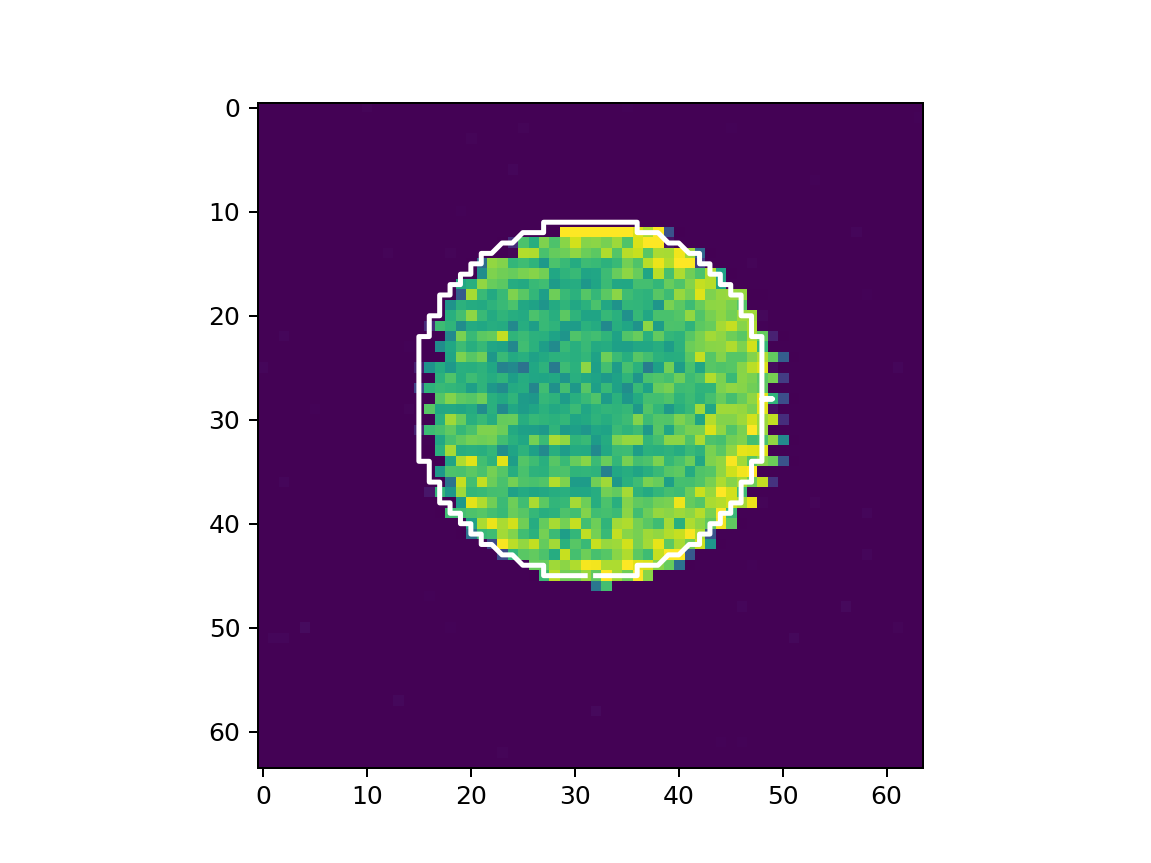

(369,) (369,)


In [21]:
# prebleach 0-1, bleach 1 - 60 , after-bleach 61 - 

t = 60
fig = plt.figure()
plt.imshow(img[:,:,t])
x0, y0 = 32.0, 28.5
# x0, y0 = rois_struc['ROI:0'][0]['X'], rois_struc['ROI:0'][0]['Y']
R = 17
t = np.linspace(0, np.pi * 2, 369)
x = x0 + R*np.sin(t)
y = y0 + R*np.cos(t)

x = np.array([int(e) for e in x])
y = np.array([int(e) for e in y])

print x.shape, y.shape
# print x

plt.plot(x,y,color='w', linewidth=2.0)

In [22]:
from skimage.filters import (sobel_h, sobel_v)

In [23]:
sh_frames = np.zeros(img.shape[:2] + (39,))
sv_frames = np.zeros(img.shape[:2] + (39,))

In [24]:
sh_frames.shape, sv_frames.shape

((64, 64, 39), (64, 64, 39))

In [25]:
for i in range(61,100):
    sh_frames[:,:,i - 61] = sobel_h(img[:,:,i])
    sv_frames[:,:,i - 61] = sobel_v(img[:,:,i])

In [26]:
np.convolve?

In [27]:
def win_average(arr, n=3):
    length = arr.shape[-1]
    result = np.zeros(arr.shape[:2] + (length - n + 1,))
    for i in range(length - n + 1):
        result[:,:,i] = arr[:,:,i:i+n].sum(axis=2)/n
    return result

In [28]:
sh_avg = win_average(sh_frames, n=5)
sv_avg = win_average(sv_frames, n=5)

In [29]:
import matplotlib.pyplot as plt
from matplotlib import animation

<IPython.core.display.Javascript object>


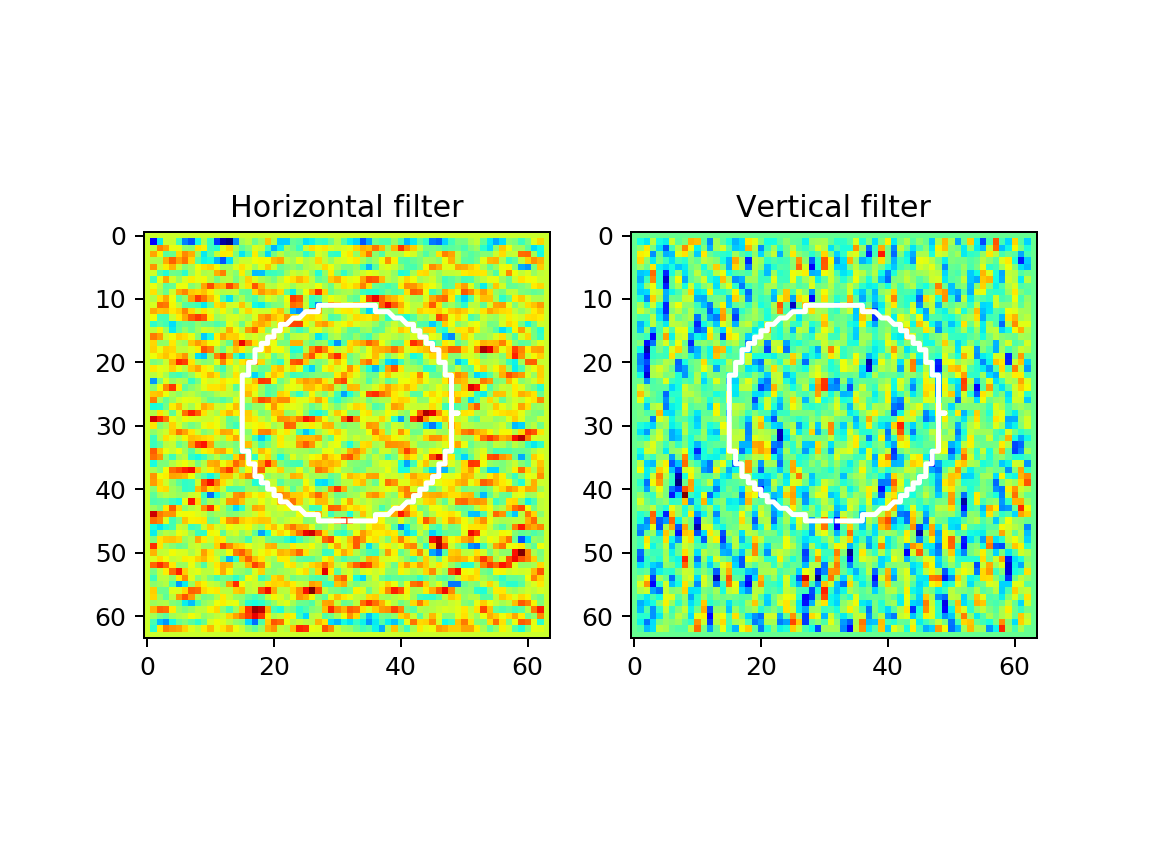

In [30]:
# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Horizontal filter')
ax2.set_title('Vertical filter')

h1 = ax1.imshow(sh_avg[:,:,0], cmap=plt.cm.jet)
h2 = ax2.imshow(sv_avg[:,:,0], cmap=plt.cm.jet)
ax1.plot(x,y,color='w', linewidth=2.0)
ax2.plot(x,y,color='w', linewidth=2.0)

def init():
    h1.set_data(np.zeros_like(sh_avg[:,:,0]))
    h2.set_data(np.zeros_like(sv_avg[:,:,0]))
    return h1, h2

def animate(i):
    h1.set_data(sh_avg[:,:,i])
    h2.set_data(sv_avg[:,:,i])
    return h1, h2
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1])#, interval=20, blit=True)
# anim.save('basic_animation_sobel.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [31]:
plt.quiver?

<IPython.core.display.Javascript object>


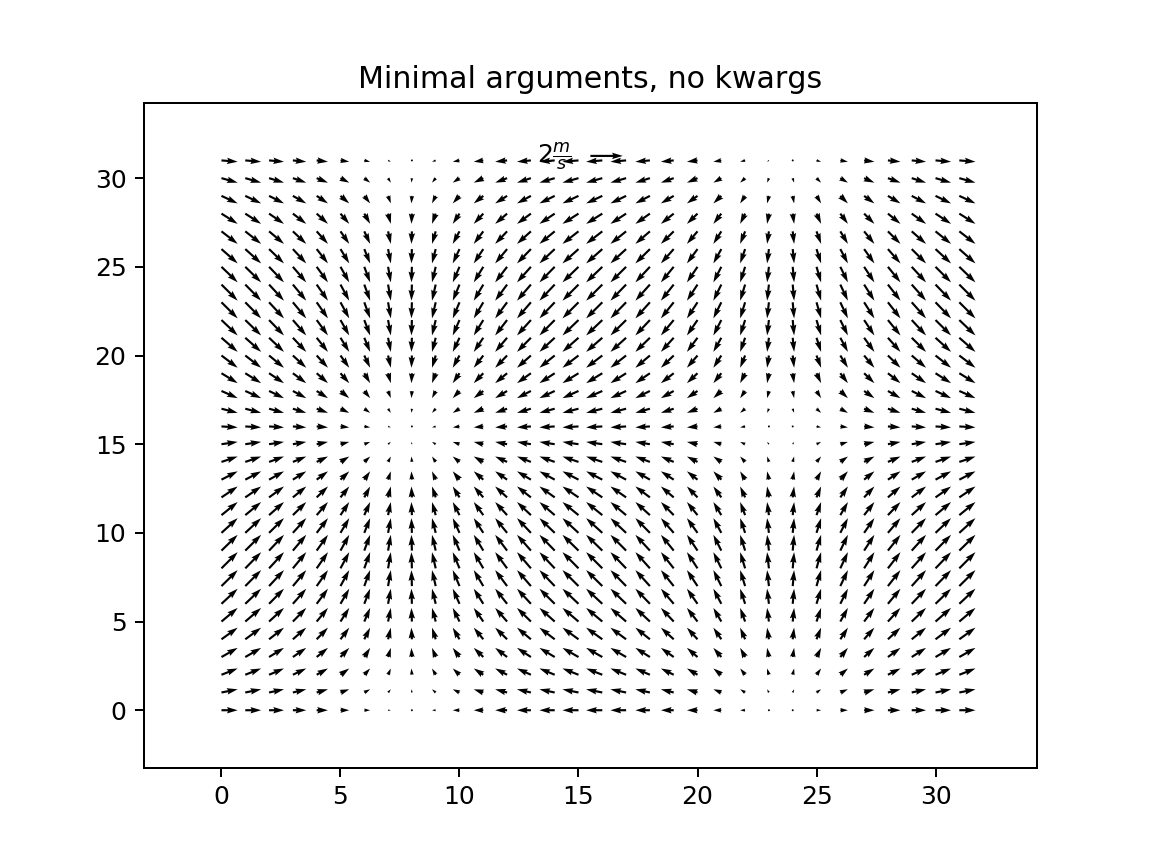

34.1 34.1


In [32]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
# print X.shape
# print X
# print 
# print 
# print Y.shape
# print Y
U = np.cos(X)
V = np.sin(Y)

# 1
plt.figure()
Q = plt.quiver(U, V)
qk = plt.quiverkey(Q, 0.5, 0.92, 2, r'$2 \frac{m}{s}$', labelpos='W',
                   fontproperties={'weight': 'bold'})
l, r, b, t = plt.axis()
dx, dy = r - l, t - b
print dx, dy
plt.axis([l - 0.05*dx, r + 0.05*dx, b - 0.05*dy, t + 0.05*dy])

plt.title('Minimal arguments, no kwargs')

<IPython.core.display.Javascript object>


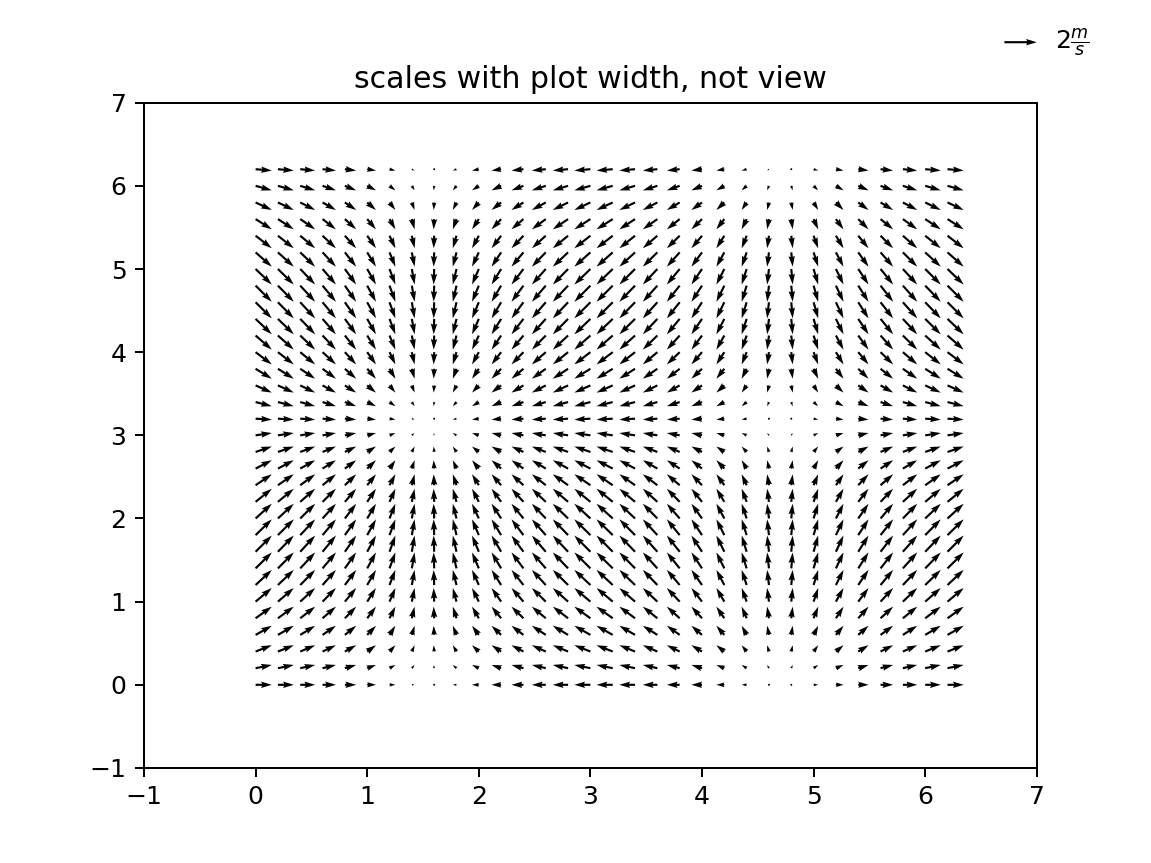

<IPython.core.display.Javascript object>


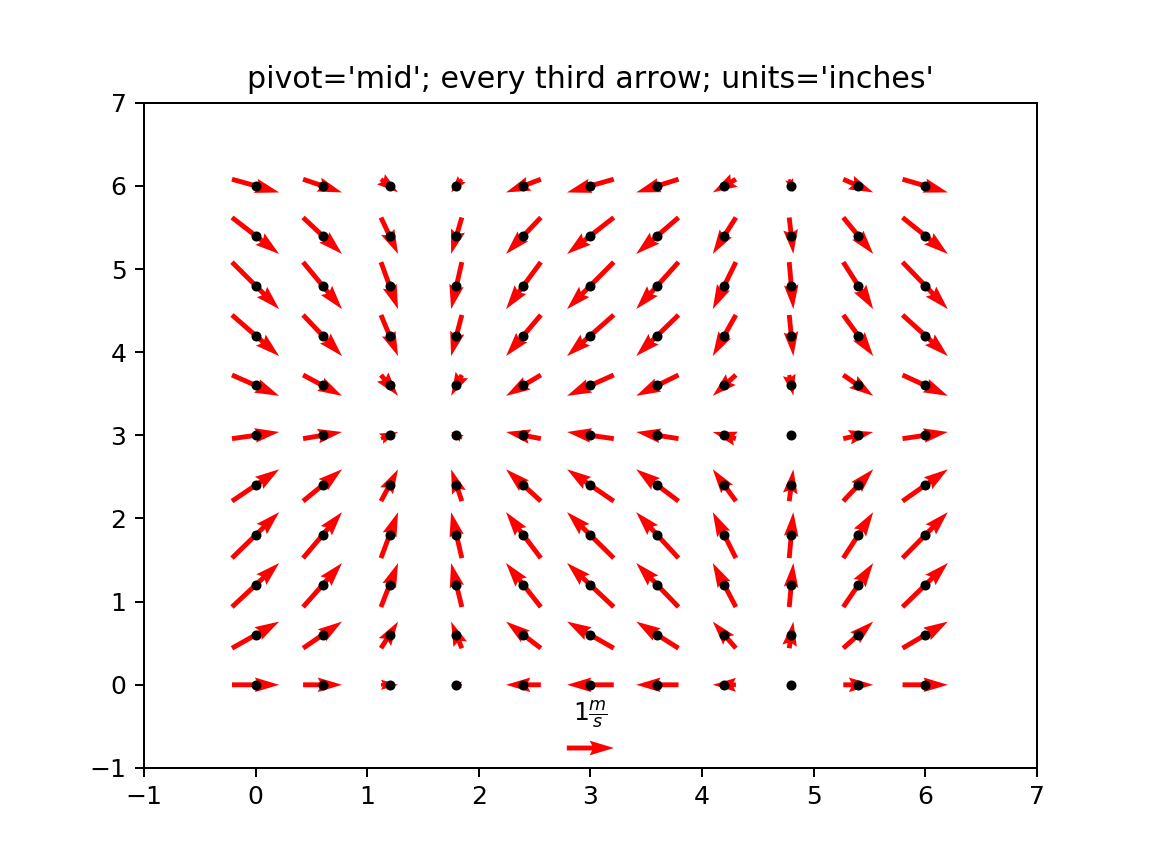

In [33]:
# 2
plt.figure()
Q = plt.quiver(X, Y, U, V, units='width')
qk = plt.quiverkey(Q, 0.9, 0.95, 2, r'$2 \frac{m}{s}$',
                   labelpos='E',
                   coordinates='figure',
                   fontproperties={'weight': 'bold'})
plt.axis([-1, 7, -1, 7])
plt.title('scales with plot width, not view')

# 3
plt.figure()
Q = plt.quiver(X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],
               pivot='mid', color='r', units='inches')
qk = plt.quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
plt.plot(X[::3, ::3], Y[::3, ::3], 'k.')
plt.axis([-1, 7, -1, 7])
plt.title("pivot='mid'; every third arrow; units='inches'")

# 4

In [34]:
img.shape

(64, 64, 369)

In [35]:
img.shape[-1]

369

In [36]:
from matplotlib import pyplot as plt
from matplotlib import animation

In [167]:
from skimage.filters import roberts
from skimage.filters import sobel
from skimage.filters import prewitt

<IPython.core.display.Javascript object>


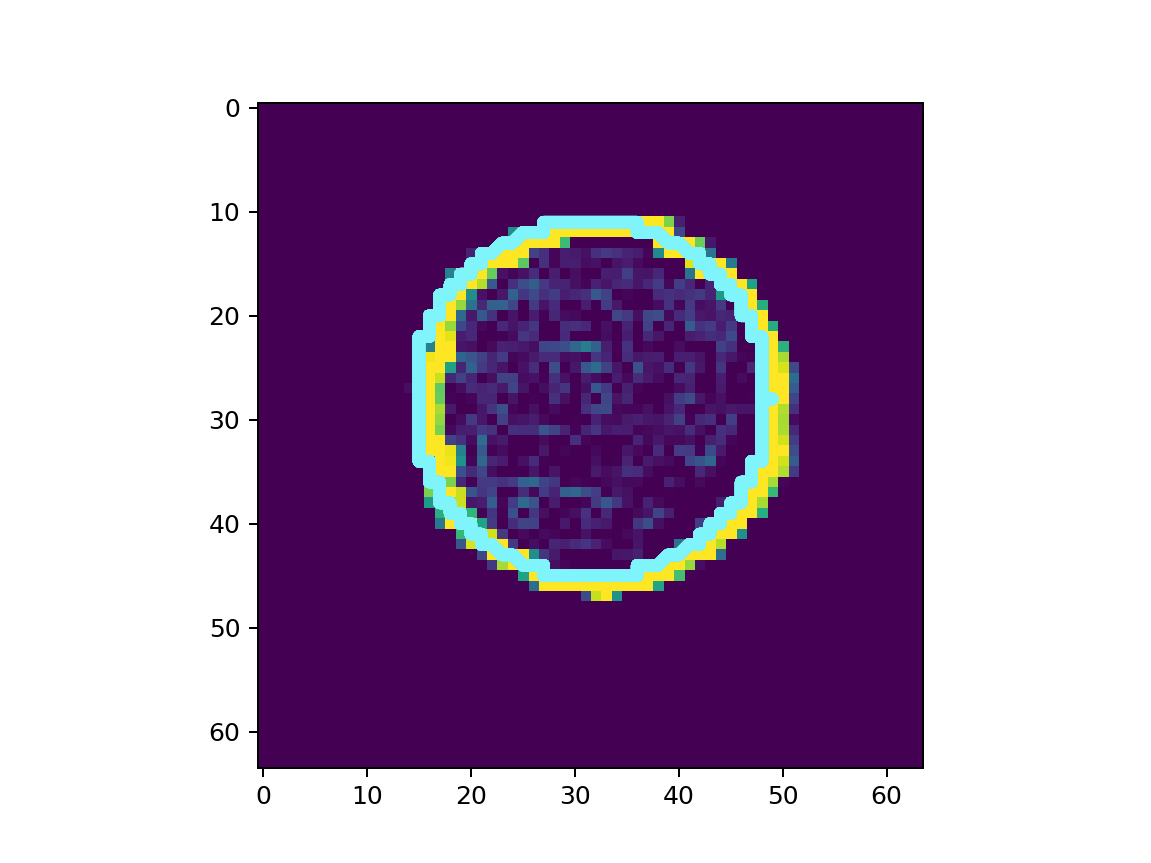

In [51]:
fig = plt.figure()
ax = plt.imshow(img[:,:,0])

def init():
    ax.set_data(np.zeros_like(img[:,:,0]))
    return ax,

def animate(i): 
#     sh_frames[:,:,i - 61] = sobel_h(img[:,:,i])
#     sv_frames[:,:,i - 61] = sobel_v(img[:,:,i])
#     ax.set_data(img[:,:,i])
    
    t = 60
    x0, y0 = 32.0, 28.5

    R = 17
    t = np.linspace(0, np.pi * 2, 369)
    x = x0 + R*np.sin(t)
    y = y0 + R*np.cos(t)
    
    x = np.array([int(e) for e in x])
    y = np.array([int(e) for e in y])

    plt.plot(x,y,color='#7ff4fa', linewidth=5.0,)
    image = img[:,:,i]
    
    
#     edge_roberts = roberts(image)
    edge_sobel = sobel(image)
    ax.set_data(edge_sobel)

    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=img.shape[-1])#, interval=20, blit=True)

# anim.save('grad.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [68]:
def edge_grad(img, func, kwargs):
    diff_grad = []
    
    min_boudary = kwargs.get('min_R', 16.7)
    max_boundary = kwargs.get('max_R', 17.3)
    R = (max_boundary + min_boudary) / 2.
    
    separation_count = kwargs.get('separation_count', 10)
    
    x0 = kwargs.get('x0', 32.0)
    y0 = kwargs.get('y0', 28.5)
    t = kwargs.get('t', 60)
    img_count = kwargs.get('img_count', 369)

    for R in np.linspace(min_boudary, max_boundary, separation_count):
        local_diff_grad = []
        for i in range(img_count):
            image = img[:,:, i]
            edge_roberts = func(image)

            t = np.linspace(0, np.pi * 2, img_count)
            x = x0 + R * np.sin(t)
            y = y0 + R * np.cos(t)
    
            local_diff_grad.append([])
            for xl, yl in zip(x, y):
                local_diff_grad[i].append(edge_roberts[int(xl), int(yl)])
            
        diff_grad.append(local_diff_grad)
    diff_grad = np.array(diff_grad).sum(axis=0) / separation_count
    return diff_grad

In [171]:
diff_grad_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.5,
        'max_R': 17.5,
        'separation_count': 20,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_roberts = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.7,
        'max_R': 17.4,
        'separation_count': 50,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_prewitt = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img.shape[-1],
        't': 60
    }
)

assert diff_grad_sobel.shape == (369, 369)
assert diff_grad_roberts.shape == (369, 369)
assert diff_grad_prewitt.shape == (369, 369)

<IPython.core.display.Javascript object>


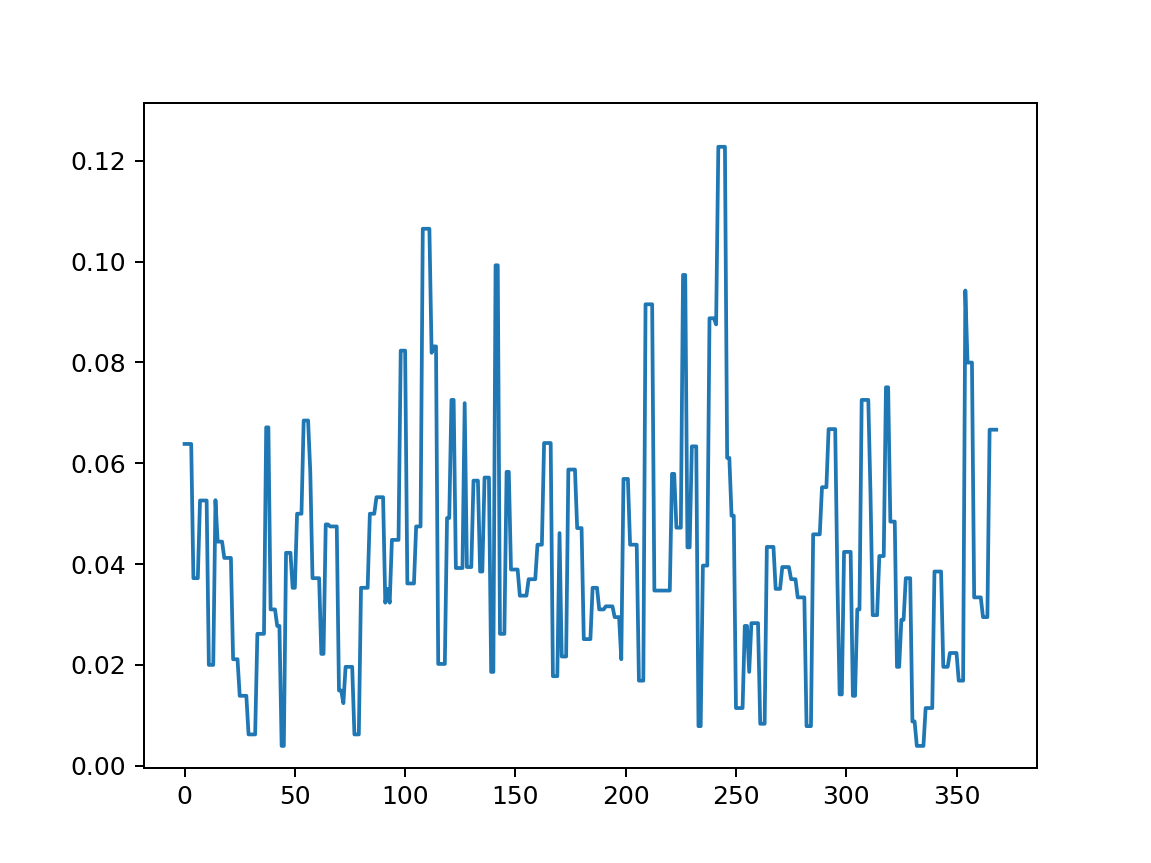

In [44]:
# STANDARD ANIMATED PLOT
def standard_plot(diff_grad, save=None):
    fig, ax = plt.subplots()

    x = np.arange(len(diff_grad[0]))
    line, = ax.plot(x, diff_grad[0])


    def animate(i):
        line.set_ydata(diff_grad[i])  # update the data
        return line,


    # Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                                  interval=25, blit=True)
    if save:
        ani.save(save, fps=30, extra_args=['-vcodec', 'libx264'])
        
    plt.show()

In [43]:
img.shape[-1]

369

<IPython.core.display.Javascript object>


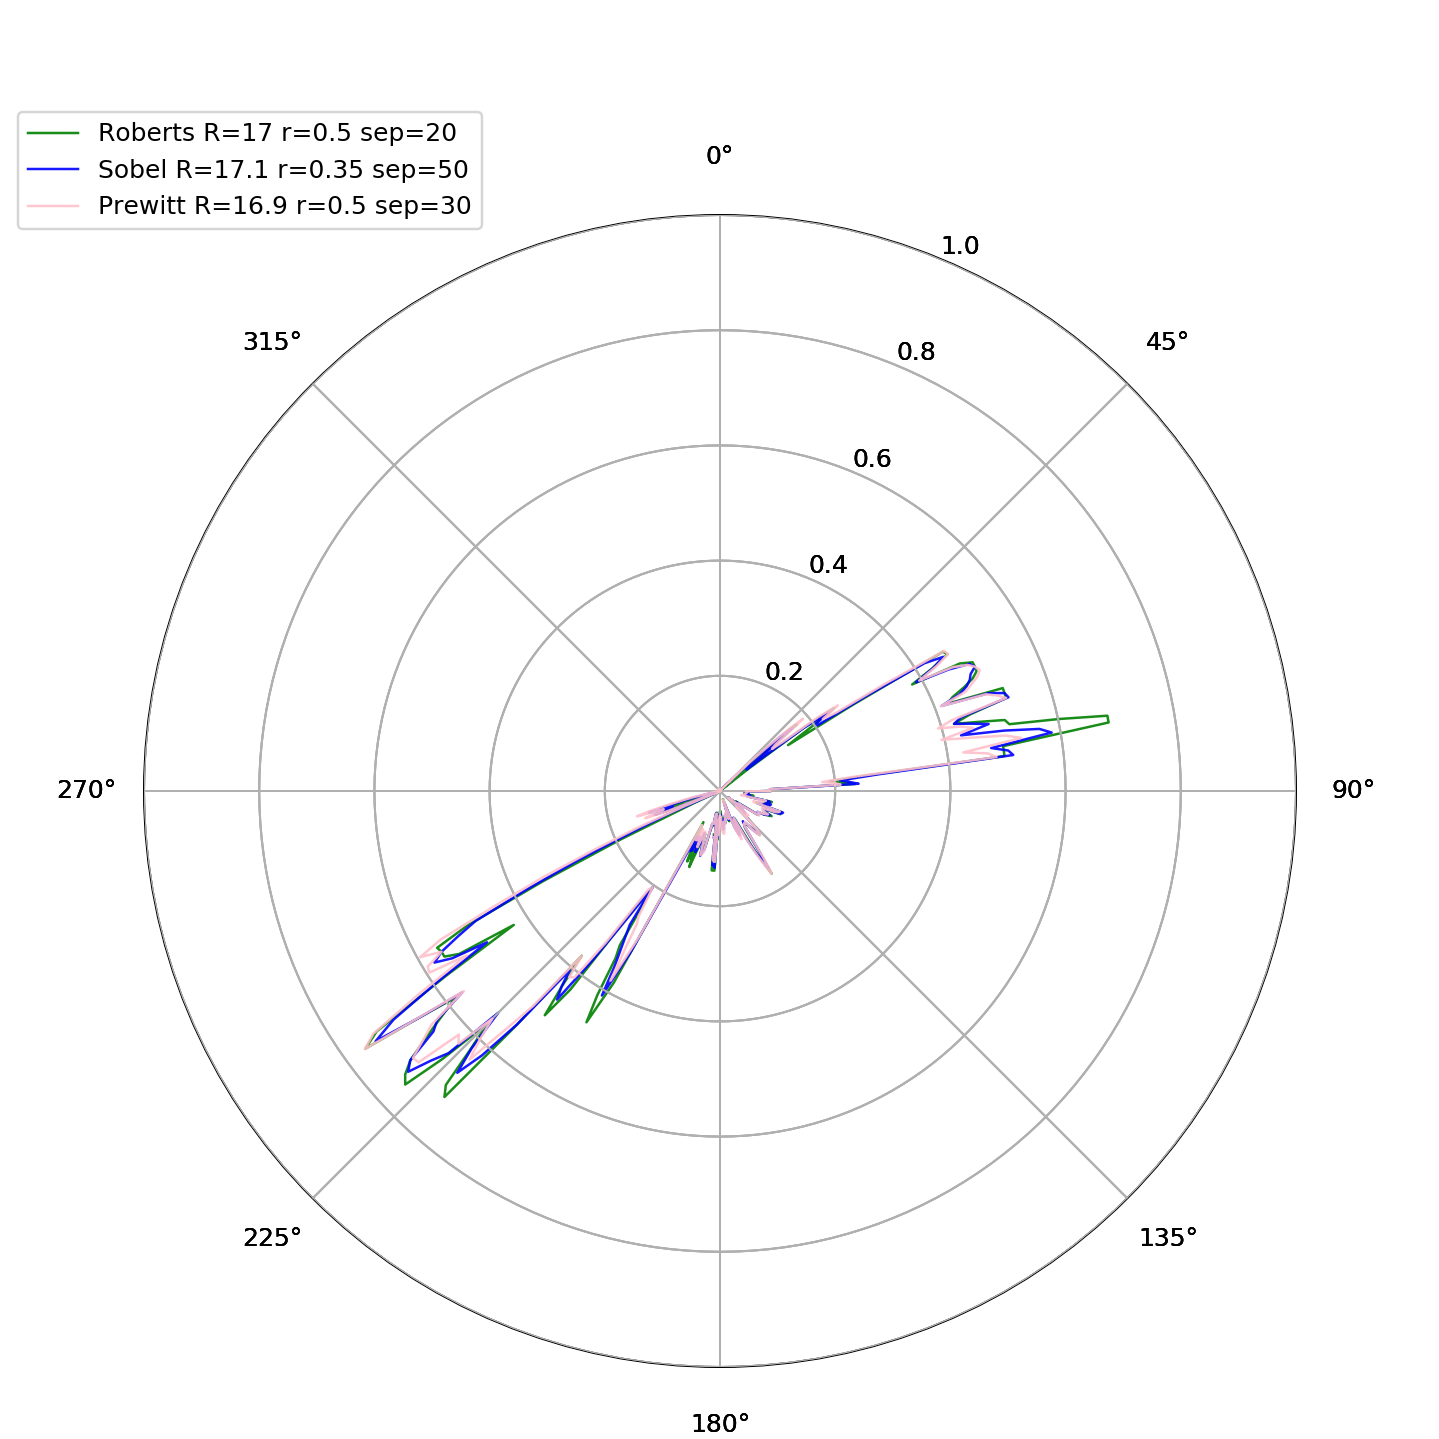

In [210]:
def data_gen():
    x = np.arange(-180.0,190.0, 370 / img.shape[-1])[:img.shape[-1]]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(img.shape[-1]):
        yield (theta, diff_grad_roberts[i], diff_grad_sobel[i], diff_grad_prewitt[i])
    
def init():
#     ax.set_ylim(0,1)
    del theta[:]
    del R1[:]
    del R2[:]
    del R3[:]
    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    return line, line2,

def polar_twin(ax):
    ax2 = ax.figure.add_axes(
        ax.get_position(), 
        projection='polar', 
        label='twin',
        frameon=False,
        theta_direction=ax.get_theta_direction(),
        theta_offset=ax.get_theta_offset()
    )

    from matplotlib.ticker import MaxNLocator

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_yticks())))

    ax2.set_ylim(0, ax2.get_yticks()[-1])

    ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)

    return ax2

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True, theta_direction=-1, theta_offset=np.pi/2)
ax.set_ylim(0, 1)
ax2 = polar_twin(ax)
ax3 = polar_twin(ax)

line, = ax.plot([], [], lw=1, alpha=.9, c='green', label='Roberts R=17 r=0.5 sep=20')
line2, = ax2.plot([], [], lw=1, alpha=.9, c='blue', label='Sobel R=17.1 r=0.35 sep=50')
line3, = ax3.plot([], [], lw=1, alpha=.9, c='pink', label='Prewitt R=16.9 r=0.5 sep=30')

ax.legend(
    [line, line2, line3],
    [line.get_label(), line2.get_label(), line3.get_label()],
    loc='upper left', bbox_to_anchor=(-0.12, 1.1)
)
# ax2.legend([line2,], [line2.get_label(),])
# ax3.legend([line3,], [line3.get_label(),])

theta, R1, R2, R3 = [], [], [], []

def run(data): 
    theta, R1, R2, R3 = data

    offset = 2.0

    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    
    return line, line2, line3,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=20, repeat=False)
# anim.save('polar_abs_grad.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
# plt.show()

<IPython.core.display.Javascript object>


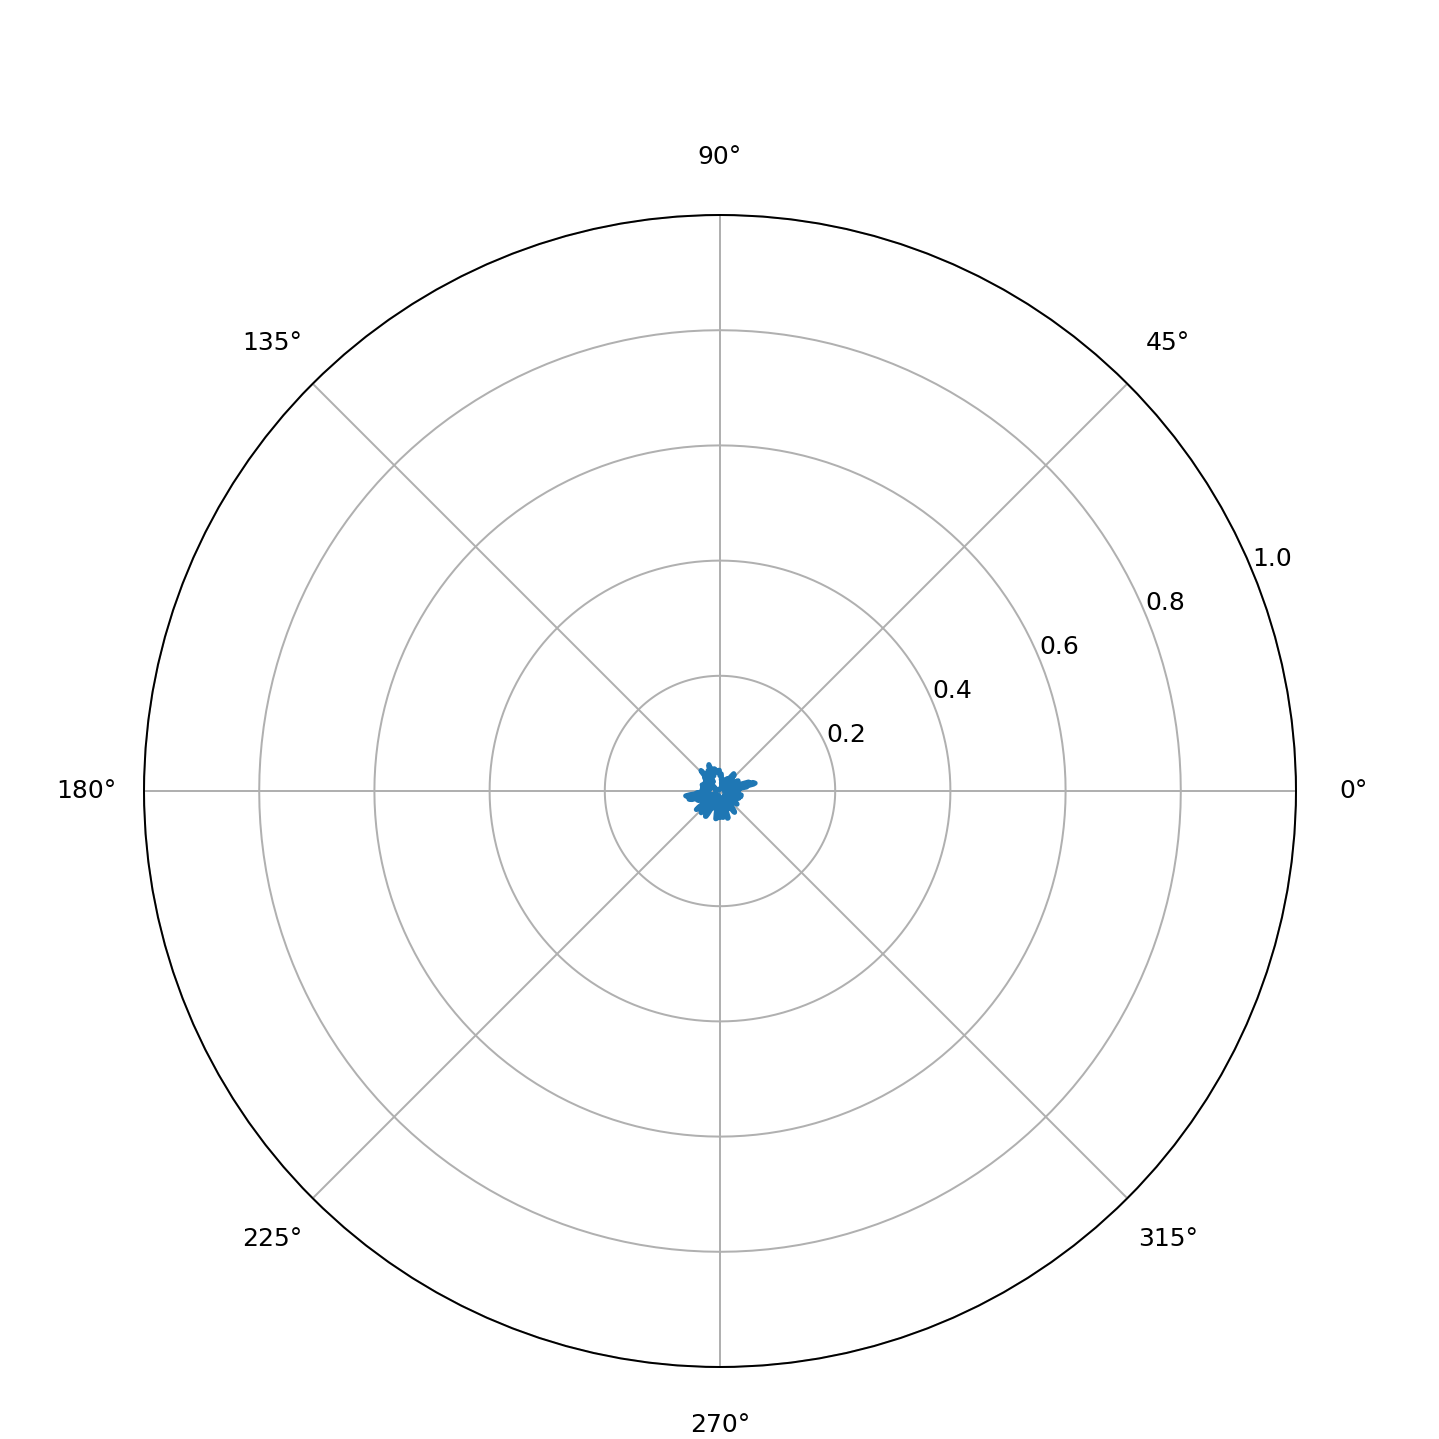

In [166]:
def data_gen():
    x = np.arange(-180.0,190.0, 1.00271)[:369]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(diff_grad.shape[-1]):
        yield (theta, diff_grad_sobel[i])
    
def init():
    ax.set_ylim(0,1)
    del theta[:]
    del R1[:]
    line.set_data(theta, R1)
    return line,

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True)
ax.set_ylim(0,2)
line, = ax.plot([], [], lw=2)

# ax.grid(1)

theta, R1 = [], []

def run(data): 
    theta, R1 = data

    offset = 2.0

    line.set_data(theta, R1)
    return line,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=100, repeat=False)
# anim.save('polar_abs_grad.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
# plt.show()



In [ ]:
HTML(anim.to_html5_video())

In [ ]:
# cut segment after bleaching
# find countour
# apply sobol filter for S_x and S_y
# get atan(S_y/S_x)
# calculate mean for some number of frames show arrow with amplitude in points


In [ ]:
from IPython.display import HTML

In [ ]:
stop_bioformats()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt


# image = camera()

In [ ]:
image = img[:,:,4]

<IPython.core.display.Javascript object>


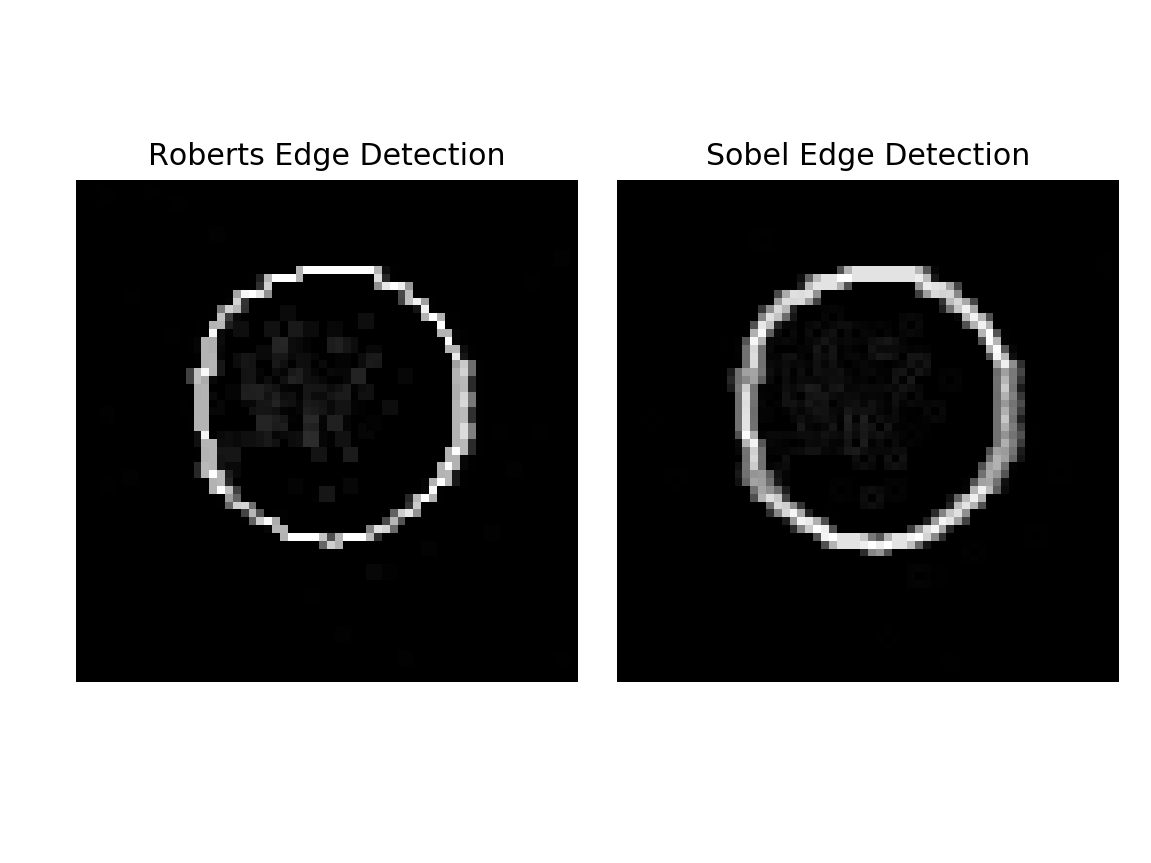

In [57]:
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

ax0.imshow(edge_roberts, cmap=plt.cm.gray)
ax0.set_title('Roberts Edge Detection')
ax0.axis('off')

ax1.imshow(edge_sobel, cmap=plt.cm.gray)
ax1.set_title('Sobel Edge Detection')
ax1.axis('off')

plt.tight_layout()

<IPython.core.display.Javascript object>


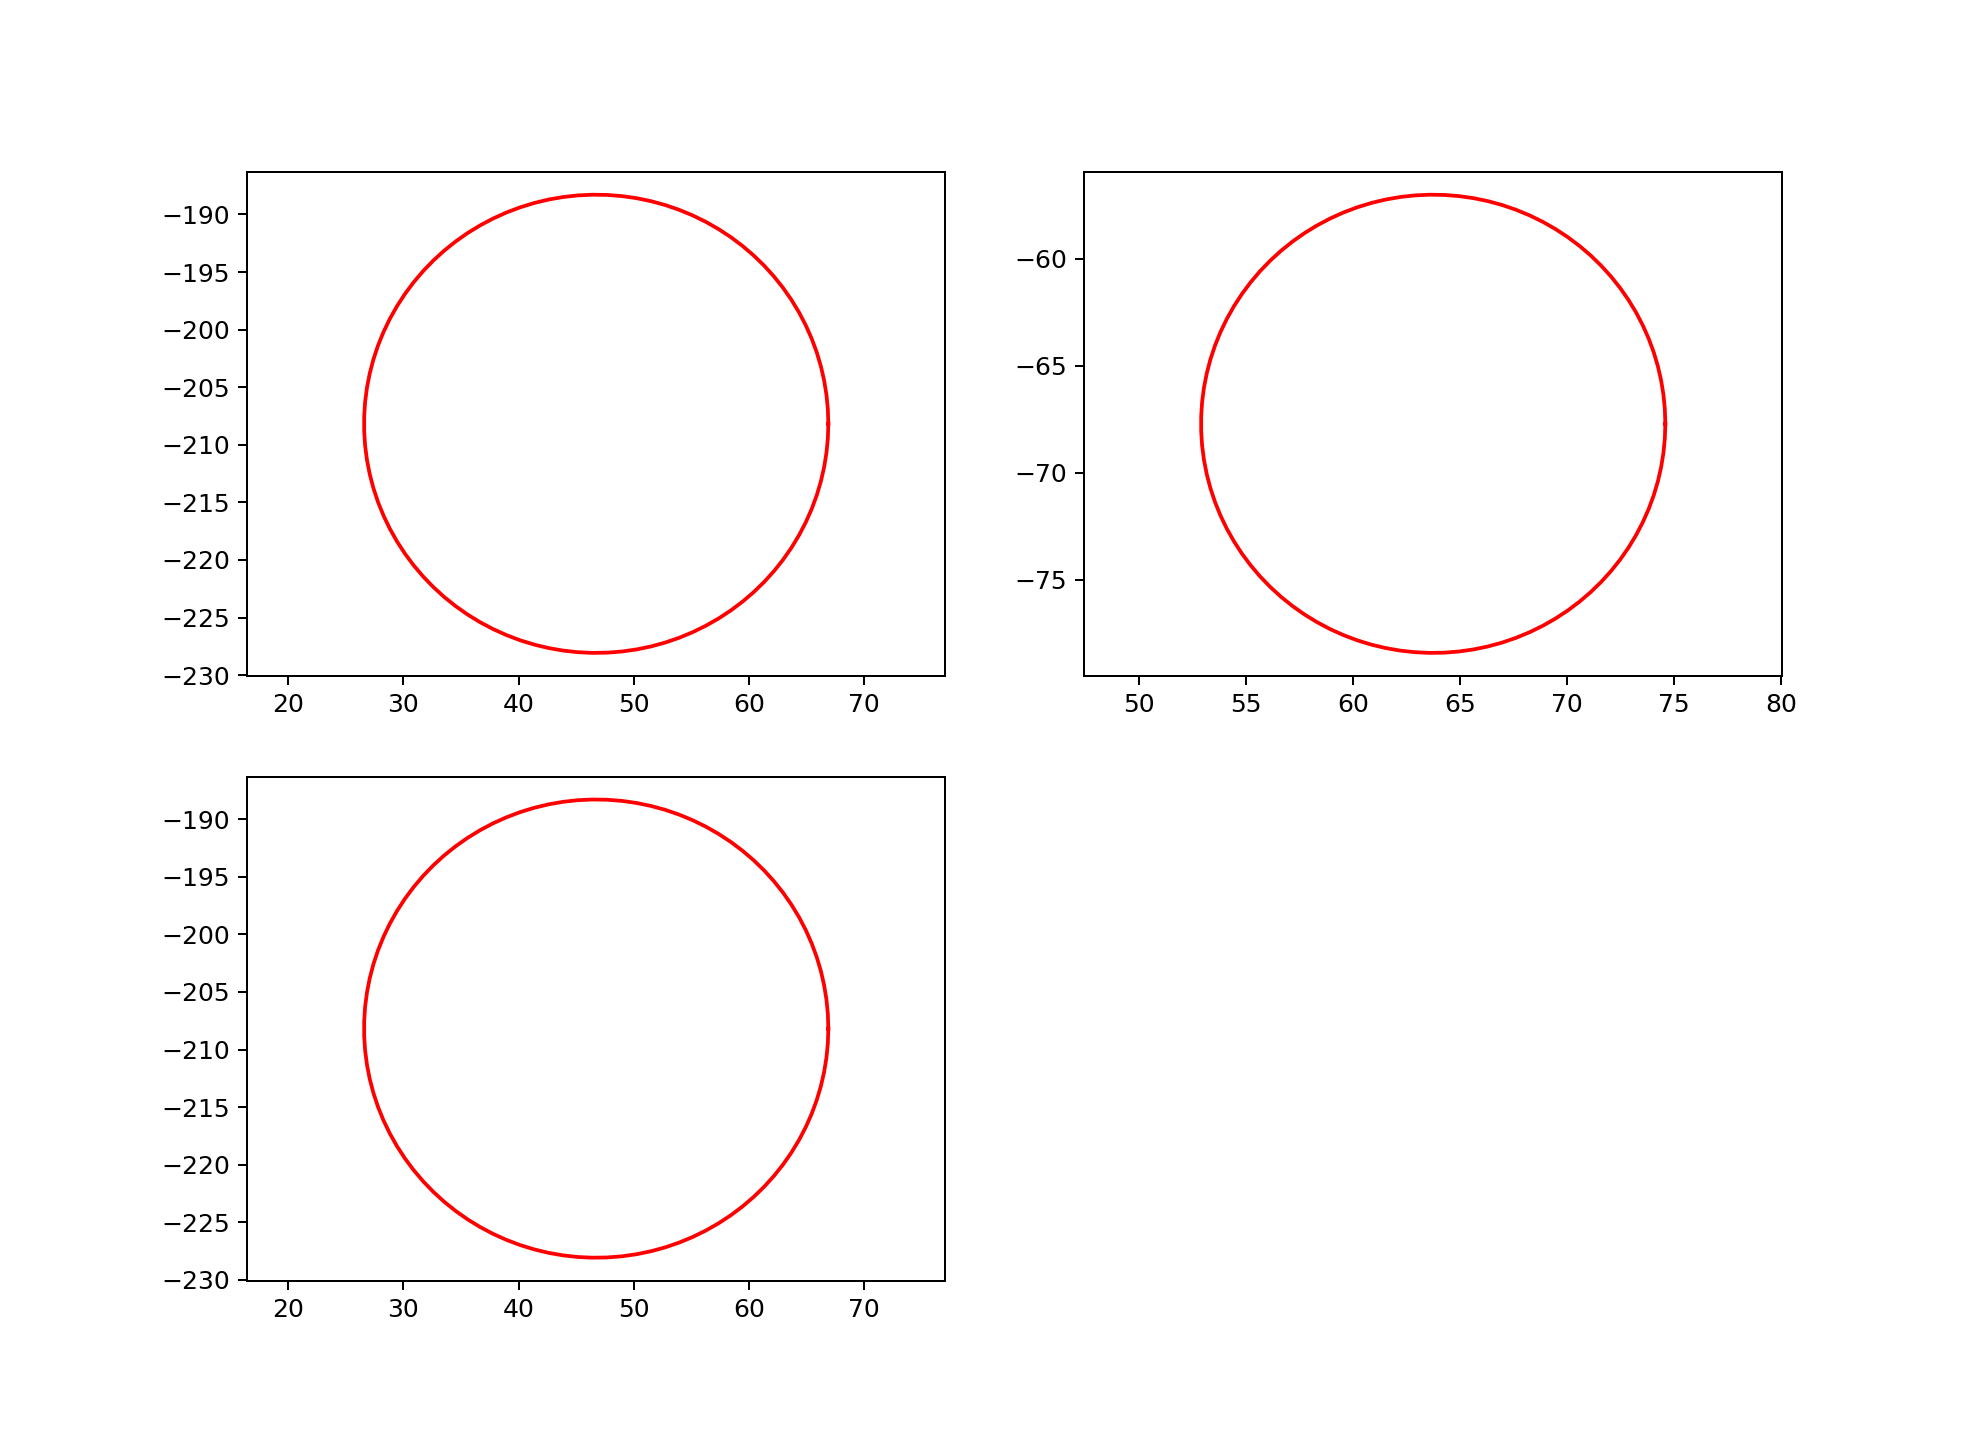

In [82]:
fig = plt.figure(figsize=(11, 8))
for _id, roi in enumerate(rois_struc):
    plt.subplot(2, 2, 1 + _id)
    poly = rois_struc[roi][1]['Polygon']
    x,y = poly.T
    plt.plot(x,y,'r-')
    plt.axis('equal')

In [83]:
from collections import defaultdict

def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k:v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v) for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
                d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d